# Import basic package and Setting basic functions

In [6]:
import numpy as np
from core import stagger_FD_coeff as sfci
from core.utils import cholesky_solver
from neal import SimulatedAnnealingSampler
from dwave.system import DWaveSampler
from core.QUBO_solvers import IterSampleSolver
from collections import ChainMap
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt

In [3]:
def solve_coeff_with_3_methods():

    # Using the real Quantum Annealing Hardware Dwave System!
    # You should sign up a count and get your API.
    # sampler = DWaveSampler(
    #     token="YOUR API TOKEN",
    #     solver="Advantage_system6.4",
    #     region="na-west-1",
    # )  #

    # Using your computer to simulate the quantum annealing.
    sampler = SimulatedAnnealingSampler()  # for test

    tra_a0_dict = {}
    for M in M_set:
        tra_a0_dict["Tra" + f" M={M}"] = sfci.Taylor_Coef(M)

    wang_a0_dict = {}
    for M, freq_max in zip(M_set, freq_max_set):
        linear_sys = sfci.Stagger_FD_coeff_1D(v, h, tao, freq_max, L=20)
        wang_a0_dict["Wang" + f" M={M}"] = linear_sys.solve(
            M=M,
            coeff_vec=sfci.Taylor_Coef(M),
            alpha=1,
            beta=1,
            epsilon=1e-8,
            max_iter_num=max_iter_num,
            mode_of_construct="lstsq",
            solver=cholesky_solver,
            show_process=False,
        )

    qa_a0_dict = {}
    for M, freq_max in zip(M_set, freq_max_set):
        linear_sys = sfci.Stagger_FD_coeff_1D(v, h, tao, freq_max, L=20)
        sis = IterSampleSolver(
            sampler=sampler,
            x0=np.ones(M) / 100,  # initial vector of Delta a
            num_sample=2000,  # for real hardware device using 2000
            R=8,
            alpha=1.0,
            beta=0.7,
            fixed_point=0,
            epsilon=1e-6,
            maxiter=5,  # max iteration in small iteration
            code_method="pn",
            resultMod="lowest_energy",
            # num_spin_reversal_transforms=10,
            postprocess=False,
        )

        qa_a0 = linear_sys.solve(
            M=M,
            coeff_vec=sfci.Taylor_Coef(M),
            epsilon=1e-8,
            max_iter_num=max_iter_num,
            mode_of_construct="direct",
            solver=sis.solve,
            show_process=False,
        )
        qa_a0_dict[f"QA M={M}"] = qa_a0

    result_dict = dict(ChainMap(qa_a0_dict, wang_a0_dict, tra_a0_dict))

    return result_dict, linear_sys

## set plot function

In [4]:
def show_disp_curve(result_dict):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=150)

    lw = 1.1  # linwidth of box
    style_set = ["-", "--", ":"]
    linwith = 1.2
    counter = 0
    for label, coeff in result_dict.items():
        sigma = linear_sys.cal_sigma(
            v * tao / h, np.linspace(pi / 1000, pi, 1000), coeff
        )
        if "Tra" in label:
            ax[0].plot(
                np.linspace(pi / 1000, pi, 1000),
                sigma,
                color="maroon",
                linewidth=linwith,
                ls=style_set[counter],
                label=label,
            )
        elif "QA" in label:
            ax[0].plot(
                np.linspace(pi / 1000, pi, 1000),
                sigma,
                color="midnightblue",
                linewidth=linwith,
                ls=style_set[counter],
                label=label,
            )
        counter = (counter + 1) % 3
        ax[0].set_ylim([0.9, 1.05])
        ax[0].set_xlim([0, 3.142])
        ax[0].set_ylabel(
            "$\delta$", fontfamily="Arial", fontsize=12, math_fontfamily="stix"
        )
        ax[0].set_xlabel(
            "$kh$", fontfamily="Arial", fontsize=12, math_fontfamily="stix"
        )
        ax[0].set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
        ax[0].set_yticks([0.9, 0.95, 1.0, 1.05])
        ax[0].spines["left"].set_linewidth(lw)
        ax[0].spines["top"].set_linewidth(lw)
        ax[0].spines["right"].set_linewidth(lw)
        ax[0].spines["bottom"].set_linewidth(lw)

        ax[0].tick_params(
            top=True,
            right=True,
            which="major",
            direction="in",
            length=4,
            width=1.0,
            colors="black",
            labelsize=8,
        )
        ax[0].xaxis.set_minor_locator(MultipleLocator(0.1))
        ax[0].yaxis.set_minor_locator(MultipleLocator(0.01))
        # ax.xaxis.set_minor_locator(AutoMinorLocator()) #  MultipleLocator(0.2)
        ax[0].tick_params(
            top=True,
            right=True,
            direction="in",
            which="minor",
            length=2,
            width=0.8,
            colors="black",
        )

        # ax[0].text(x=-0.25, y=1.05, s='(a)', fontfamily='serif', fontsize=12)

        ax[0].grid(
            visible=True, axis="both", which="major", linestyle="--", linewidth=0.5
        )
        ax[0].legend(
            title="",
            fontsize="x-small",
            loc="lower left",
            borderpad=1.0,
            borderaxespad=2.0,
            labelspacing=0.5,
            edgecolor="black",
            handlelength=2.0,
        )

    counter = 0
    for label, coeff in result_dict.items():
        sigma = linear_sys.cal_sigma(
            v * tao / h, np.linspace(pi / 1000, pi, 1000), coeff
        )
        if "Wang" in label:
            ax[1].plot(
                np.linspace(pi / 1000, pi, 1000),
                sigma,
                color="maroon",
                linewidth=linwith,
                ls=style_set[counter],
                label=label,
            )
        elif "QA" in label:
            ax[1].plot(
                np.linspace(pi / 1000, pi, 1000),
                sigma,
                color="midnightblue",
                linewidth=linwith,
                ls=style_set[counter],
                label=label,
            )
        counter = (counter + 1) % 3
        ax[1].set_ylim([0.9, 1.05])
        ax[1].set_xlim([0, 3.142])
        ax[1].set_ylabel(
            "$\delta$",
            fontfamily="Arial",
            fontsize=12,
            math_fontfamily="stix",
        )
        ax[1].set_xlabel(
            "$kh$", fontfamily="Arial", fontsize=12, math_fontfamily="stix"
        )
        ax[1].set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
        ax[1].set_yticks([0.9, 0.95, 1.0, 1.05])
        ax[1].spines["left"].set_linewidth(lw)
        ax[1].spines["top"].set_linewidth(lw)
        ax[1].spines["right"].set_linewidth(lw)
        ax[1].spines["bottom"].set_linewidth(lw)

        ax[1].tick_params(
            top=True,
            right=True,
            which="major",
            direction="in",
            length=4,
            width=1.0,
            colors="black",
            labelsize=8,
        )
        ax[1].xaxis.set_minor_locator(MultipleLocator(0.1))
        ax[1].yaxis.set_minor_locator(MultipleLocator(0.01))
        # ax.xaxis.set_minor_locator(AutoMinorLocator()) #  MultipleLocator(0.2)
        ax[1].tick_params(
            top=True,
            right=True,
            direction="in",
            which="minor",
            length=2,
            width=0.8,
            colors="black",
        )

        ax[1].grid(
            visible=True, axis="both", which="major", linestyle="--", linewidth=0.5
        )
        ax[1].legend(
            title="",
            fontsize="x-small",
            loc="lower left",
            borderpad=1.0,
            borderaxespad=2.0,
            labelspacing=0.5,
            edgecolor="black",
            handlelength=2.0,
        )
    return fig, ax

## Low-Speed Medium

Current object function value is 1.6383177586334437e-06
~~~~~~~~ Start 1 iteration ~~~~~~~~
Current coeff_vec is:
[[ 0.29878423  0.37066199 -0.10944947 -0.13116153]]
Current object function value is 0.05466949146345883
~~~~~~~~ Start 2 iteration ~~~~~~~~
Current coeff_vec is:
[[ 0.41793356  0.44343805 -0.22715186  0.02578985]]
Current object function value is 0.003977215502417436
~~~~~~~~ Start 3 iteration ~~~~~~~~
Current coeff_vec is:
[[ 0.46754519  0.45320541 -0.25729121  0.07909612]]
Current object function value is 0.0002687266878155214
~~~~~~~~ Start 4 iteration ~~~~~~~~
Current coeff_vec is:
[[ 0.60894466  0.35212801 -0.20924554  0.06686997]]
Current object function value is 0.00015969290199074047
~~~~~~~~ Start 5 iteration ~~~~~~~~
Current coeff_vec is:
[[ 1.00051597  0.06456409 -0.06415361  0.02260894]]
Current object function value is 1.977903860398736e-05
~~~~~~~~ Start 6 iteration ~~~~~~~~
Current coeff_vec is:
[[ 1.18551136 -0.07151961  0.00462706  0.00141785]]
Current obj

d:\OneDrive\OneDrive - mails.ucas.ac.cn\Research\2_Monthly_Report\2024博三下半学期\Seismic wave propagation simulation with QC\code_for_the_paper\Solution_of_Forward_Operator\core\QUBO_solvers.py:135: UserWarning: 'embedding' indicates the way mapping our problem  If not specified, the default settings('minor_embedding')  will be used for DWaveSampler.
  warnings.warn(
d:\OneDrive\OneDrive - mails.ucas.ac.cn\Research\2_Monthly_Report\2024博三下半学期\Seismic wave propagation simulation with QC\code_for_the_paper\Solution_of_Forward_Operator\core\QUBO_solvers.py:654: UserWarning: 'codingMod' indicates the way bit string to represent a number! It contain three mod, 'p', 'n', 'pn' If not specified, the default Settings will be used
  warnings.warn(


* QPU access time: 200767.16 us
* The sampling time in 1 iteration was: 3.84 s
* Current Object Function is 0.035000898862901836
* The step size of current iteration:-0.24785509163378308

* QPU access time: 200766.76 us
* The sampling time in 2 iteration was: 4.00 s
* Current Object Function is 0.007677323134470102
* The step size of current iteration:-0.12344142422901959

* QPU access time: 200766.76 us
* The sampling time in 3 iteration was: 3.30 s
* Current Object Function is 0.004783018851072037
* The step size of current iteration:-0.05026210742086709

* QPU access time: 200766.76 us
* The sampling time in 4 iteration was: 3.35 s
* Current Object Function is 0.0016755150493413956
* The step size of current iteration:-0.018552729528355842

* QPU access time: 200766.76 us
* The sampling time in 5 iteration was: 3.46 s
* Current Object Function is 0.0008163097858003726
Satisfying the termination condition, stop the iteration.
The lowest obj funciton is 0.0008163097858003726

Current 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


* QPU access time: 265368.76 us
* The sampling time in 5 iteration was: 1.32 s
* Current Object Function is 0.001990156631999511
Satisfying the termination condition, stop the iteration.
The lowest obj funciton is 0.001990156631999511

Current coeff_vec is:
[[ 1.38479243 -0.24460933  0.13556791 -0.08690005  0.05254115 -0.02866846
   0.01218442 -0.004323  ]]
Current object function value is 3.960708625320903e-06


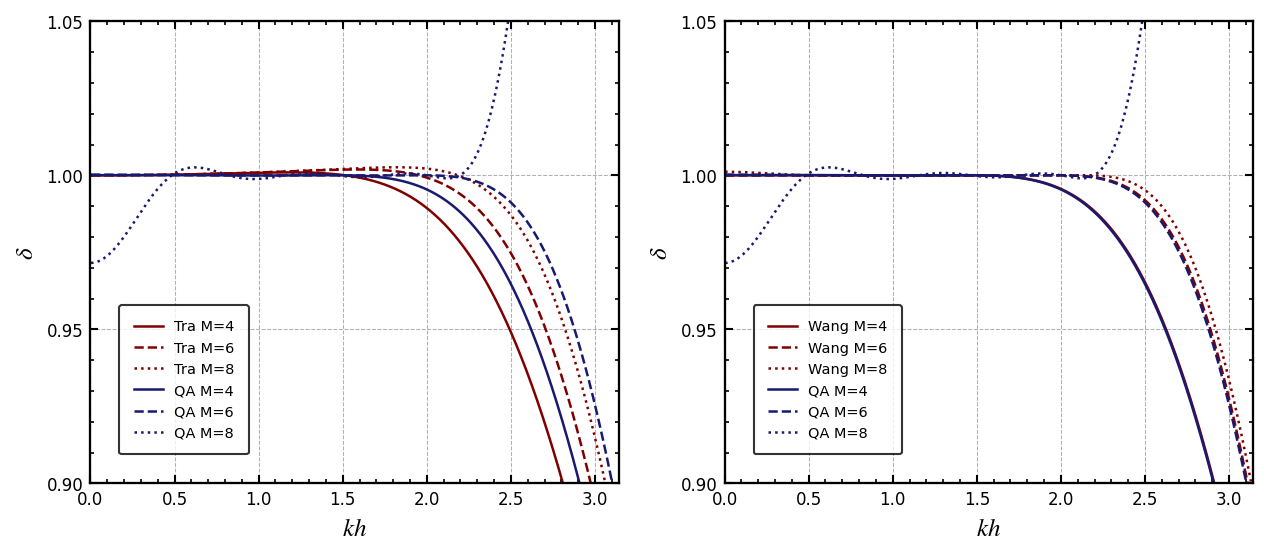

In [5]:
pi = np.pi

v = 1500
h = 10
tao = 0.001
freq_max_set = [39, 51, 55]
M_set = [4, 6, 8]
max_iter_num = 20
result_dict, linear_sys = solve_coeff_with_3_methods()
fig, ax = show_disp_curve(result_dict)
# fig.savefig("1D_low_velocity_reuslt.png", dpi=300)
# fig.savefig("1D_low_velocity_reuslt.pdf", dpi=600, format="pdf")

## High-Speed Medium

Current object function value is 0.0008626207483604833
~~~~~~~~ Start 1 iteration ~~~~~~~~
Current coeff_vec is:
[[ 0.29404892  0.3663317  -0.10478594 -0.1294096 ]]
Current object function value is 0.05082097078501878
~~~~~~~~ Start 2 iteration ~~~~~~~~
Current coeff_vec is:
[[ 0.40924188  0.43739044 -0.21772502  0.02246174]]
Current object function value is 0.0038739614899636395
~~~~~~~~ Start 3 iteration ~~~~~~~~
Current coeff_vec is:
[[ 0.45797309  0.44787261 -0.24851412  0.07568984]]
Current object function value is 0.000243238873319565
~~~~~~~~ Start 4 iteration ~~~~~~~~
Current coeff_vec is:
[[ 0.59121402  0.35284656 -0.20353528  0.06444939]]
Current object function value is 0.00014438644385262808
~~~~~~~~ Start 5 iteration ~~~~~~~~
Current coeff_vec is:
[[ 0.96532506  0.07817008 -0.06499806  0.02225676]]
Current object function value is 1.8264368119673274e-05
~~~~~~~~ Start 6 iteration ~~~~~~~~
Current coeff_vec is:
[[ 1.1448377  -0.05385512  0.00171329  0.00173168]]
Current obj

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


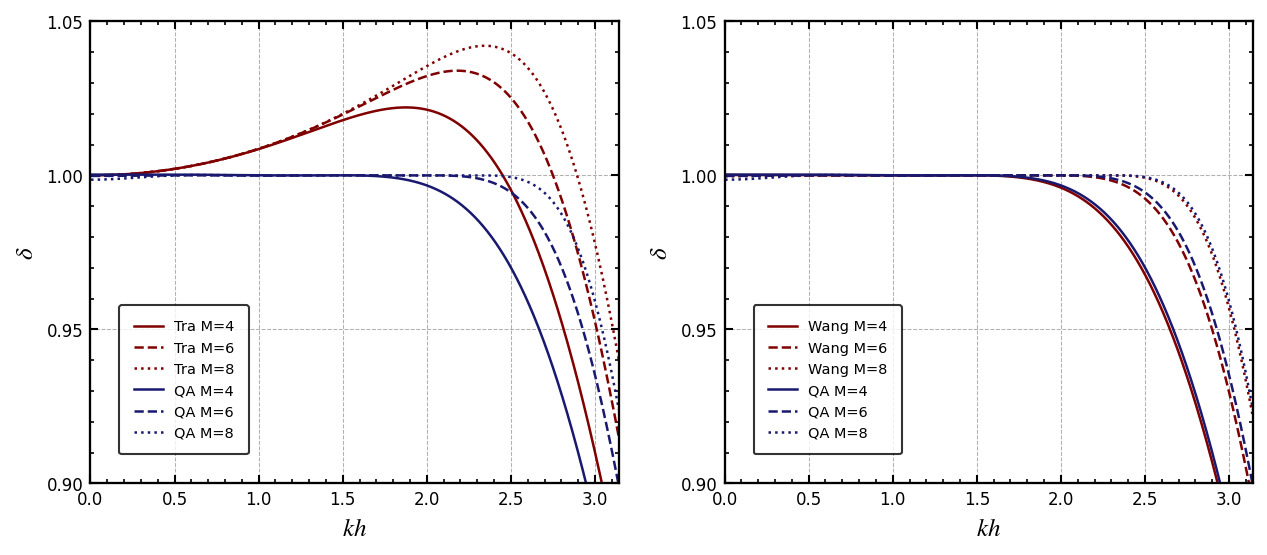

In [ ]:
v = 4500
h = 10
tao = 0.001
freq_max_set = [120, 156, 174]
M_set = [4, 6, 8]
max_iter_num = 30
result_dict, linear_sys = solve_coeff_with_3_methods()
fig, ax = show_disp_curve(result_dict)
# fig.savefig("1D_high_velocity_reuslt.png", dpi=300)
# fig.savefig("1D_high_velocity_reuslt.pdf", dpi=600, format="pdf")